### Machine Lerning Course - Final Project
#### Lior Ben Ari

#### All imports

In [ ]:
import numpy as np
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
import statistics
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import requests
from tqdm import tqdm
import shutil
import gzip

#### Parameters (Etid it as needed)

In [ ]:
download_dataset = False # Set to true at first run. 

#### Download OSSL Dataset (if required)
Link for website: https://docs.soilspectroscopy.org/index.html#ossl-mongodb

In [ ]:
if download_dataset:
    url = "https://storage.googleapis.com/soilspec4gg-public/ossl_all_L0_v1.2.csv.gz"
    response = requests.get(url, stream=True)

    # Download data
    with open("ossl_all_L0_v1.2.csv.gz", "wb") as handle:
        for data in tqdm(response.iter_content(chunk_size=8192)):
            handle.write(data)

    # Unzip file
    with gzip.open("ossl_all_L0_v1.2.csv.gz", "rb") as f_in:
        with open("ossl_all_L0_v1.2.csv", "wb") as f_out:
            shutil.copyfileobj(f_in, f_out)

    print("Download Completed")


##### Machine Learning Functions. I will use this functions later.

##### Random Forest:

In [ ]:
def Random_Forest_Model(train_X, train_y, test_X, test_y): 
    rf_model = RandomForestRegressor()
    
    param_grid = {
        'n_estimators': [100]
    }

    rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=4, scoring='r2', verbose=1, n_jobs=-1)
    rf_grid_search.fit(train_X, train_y)

    best_rf_model = rf_grid_search.best_estimator_
    best_rf_model.fit(train_X, train_y)

    validation_prediction = best_rf_model.predict(test_X)

    mae = mean_absolute_error(y_true=test_y, y_pred=validation_prediction)
    r_squared_predicion = r2_score(y_true=test_y, y_pred=validation_prediction)
    r_squared_grid_search = rf_grid_search.best_score_
    best_params = rf_grid_search.best_params_

    return validation_prediction, mae, r_squared_predicion, r_squared_grid_search, best_params

##### PLSR

In [ ]:
def PLSR_Model(train_X, train_y, test_X, test_y):
    plsr_model = PLSRegression()
    # PLSR hyperparameters dict:
    plsr_param_grid = {
        'n_components': range(1, 30, 2)
    }
    plsr_grid_search = GridSearchCV(estimator=plsr_model, param_grid=plsr_param_grid, cv=4, scoring='r2', verbose=1, n_jobs=-1)
    plsr_grid_search.fit(train_X, train_y)

    best_plsr_model = plsr_grid_search.best_estimator_
    best_plsr_model.fit(train_X, train_y)

    validation_prediction = best_plsr_model.predict(test_X)

    mae = mean_absolute_error(y_true=test_y, y_pred=validation_prediction)
    r_squared_predicion = r2_score(y_true=test_y, y_pred=validation_prediction)
    r_squared_grid_search = plsr_grid_search.best_score_
    best_params = plsr_grid_search.best_params_

    return validation_prediction, mae, r_squared_predicion, r_squared_grid_search, best_params

##### Additional helper functions

In [4]:
def gen_parityplot(targets, preds, model_name):
    plt.figure()
    min_val = min(min(targets), min(preds))
    max_val = max(max(targets), max(preds))
    ax = sns.scatterplot(x=preds, y=targets)
    x = [min_val, max_val]
    y = [min_val, max_val]
    plt.plot(x,y, color='red')
    plt.xlabel('Predictions')
    plt.ylabel('Targets')
    plt.title(f"{model_name} Parity Plot")
    ax.set_facecolor("lavender")

##### Read dataset and get its shape. Look how many samples have both Vis-NIR and EC data.

In [9]:
first_run = False
usa_carbon_col = "c.tot_usda.a622_w.pct"
europe_carbon_col = "c.tot_iso.10694_w.pct"

if first_run:
    # Read entire database
    full_dataset_df = pd.read_csv("ossl_all_L0_v1.2.csv")
    print(f"Full dataset shape: {full_dataset_df.shape}")

    visnir_col = "scan_visnir.350_ref"

    # filter by Vis-NIR existance:
    visnir_dataset_df = full_dataset_df[full_dataset_df[visnir_col].notna()]

    # filter by USA EC existance:
    usa_visnir_dataset_df = visnir_dataset_df[visnir_dataset_df[usa_carbon_col].notna()]
    # filter by Europe EC existance:
    europe_visnir_dataset_df = visnir_dataset_df[visnir_dataset_df[europe_carbon_col].notna()]

    print(f"Visnir + USA Carbon Shape: {usa_visnir_dataset_df.shape}")
    print(f"Visnir + Europe Carbon Shape: {europe_visnir_dataset_df.shape}")


##### We have 19,807 samples with both Vis-NIR and total carbon in the USA samples. Keep it as separated file

In [6]:
if first_run:
    usa_visnir_dataset_df.to_csv("Datasets/OSSL_db_filtered.csv")

##### Read filtered dataframe

In [7]:
ossl_df = pd.read_csv("Datasets/OSSL_db_filtered.csv")

C:\Users\Lior Ben Ari\AppData\Local\Temp\ipykernel_9144\909641581.py:1: DtypeWarning: Columns (5,112,113,114,115,116,117,118,119,120,121,122) have mixed types. Specify dtype option on import or set low_memory=False.
  ossl_df = pd.read_csv("Datasets/OSSL_db_filtered.csv")


##### Show target (carbon) distribution

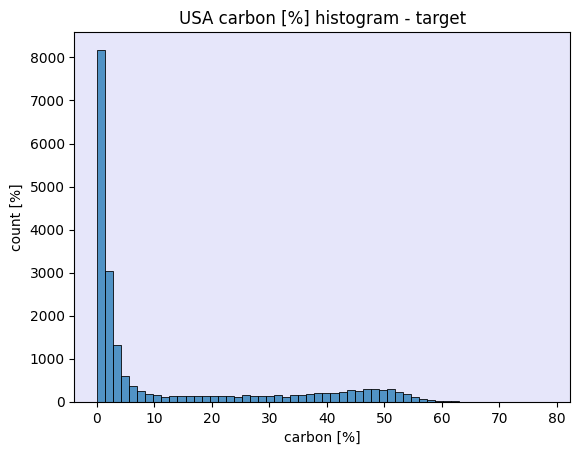

In [10]:
plt.figure()
ax = sns.histplot(data=ossl_df[usa_carbon_col])
plt.title("USA carbon [%] histogram - target")
plt.xlabel("carbon [%]", fontsize=10)
plt.ylabel("count [%]", fontsize=10)
ax.set_facecolor("lavender")

##### Split database to train and test samples. Show carbon's histogram for both train and test sets

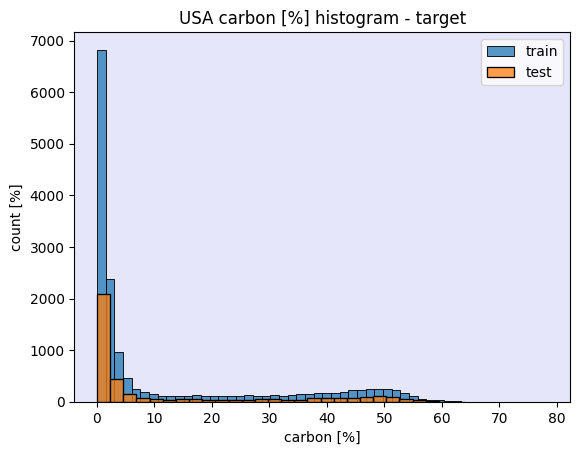

In [11]:
train_df, test_df = train_test_split(ossl_df, test_size=0.2, shuffle=True, random_state=42)
ax = sns.histplot(data=train_df[usa_carbon_col], label="train")
ax = sns.histplot(data=test_df[usa_carbon_col], label="test")
plt.title("USA carbon [%] histogram - target")
plt.xlabel("carbon [%]", fontsize=10)
plt.ylabel("count [%]", fontsize=10)
plt.legend()
ax.set_facecolor("lavender")

In [12]:
first_wl = 450
last_wl = 2450

first_wl_col_idx = list(ossl_df.columns).index(f"scan_visnir.{first_wl}_ref")
last_wl_col_idx = list(ossl_df.columns).index(f"scan_visnir.{last_wl}_ref")

train_spectroscopies = np.array(train_df.iloc[:, first_wl_col_idx:last_wl_col_idx+1], dtype=np.float64)
train_target = np.array(train_df[usa_carbon_col], dtype=np.float64)

test_spectroscopies = np.array(test_df.iloc[:, first_wl_col_idx:last_wl_col_idx+1], dtype=np.float64)
test_target = np.array(test_df[usa_carbon_col], dtype=np.float64)

print(f"train num of samples: {len(train_target)}")
print(f"train num of samples: {len(test_target)}")

train num of samples: 15845
train num of samples: 3962


##### Prediction with SavGol filtering + first derivation

Fitting 4 folds for each of 1 candidates, totalling 4 fits
xxxxxxx SavGol + 1st deriv Random Forest Results: xxxxxxx
r2 test: 0.959442720483756
r2 cv: 0.9587290323155826
best params: {'n_estimators': 100}

Fitting 4 folds for each of 6 candidates, totalling 24 fits
xxxxxxx SavGol + 1st deriv PLSR Results: xxxxxxx
r2 test: 0.8811422461484637
r2 cv: 0.8824159079347283
best params: {'n_components': 26}



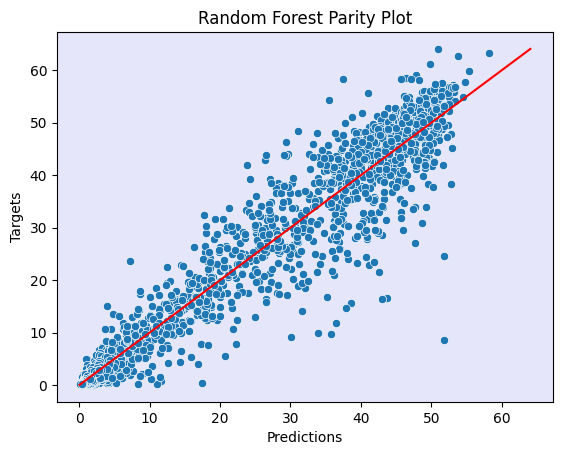

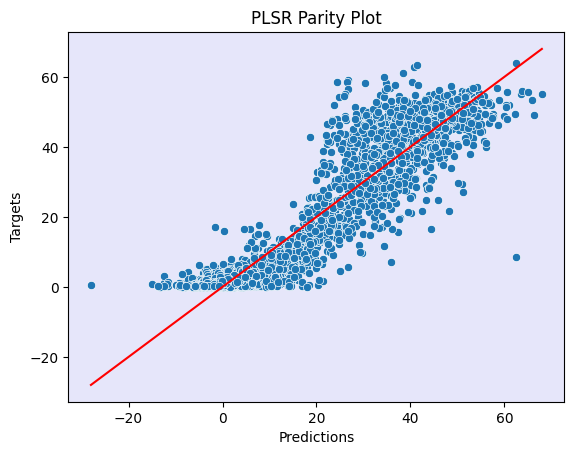

In [ ]:
train_spectroscopies_savgol_1st_deriv = savgol_filter(train_spectroscopies, window_length=11, polyorder=2, deriv=1)
test_spectroscopies_savgol_1st_deriv = savgol_filter(test_spectroscopies, window_length=11, polyorder=2, deriv=1)

# Keep resolution of 10nm:
train_spectroscopies_savgol_1st_deriv = [t[::5] for t in train_spectroscopies_savgol_1st_deriv]
test_spectroscopies_savgol_1st_deriv = [t[::5] for t in test_spectroscopies_savgol_1st_deriv]

train_X = train_spectroscopies_savgol_1st_deriv
train_y = train_target
test_X = test_spectroscopies_savgol_1st_deriv
test_y = test_target

# Random Forest:
test_pred, mae, r2_predicion, r2_grid_search, best_params = Random_Forest_Model(train_X=train_X, train_y=train_y, test_X=test_X, test_y=test_y)
print("xxxxxxx SavGol + 1st deriv Random Forest Results: xxxxxxx")
print(f"MAE: {mae}")
print(f"r2 test: {r2_predicion}")
print(f"r2 cv: {r2_grid_search}")
print(f"best params: {best_params}")
print()
gen_parityplot(test_y, test_pred, model_name="Random Forest")

# PLSR:
test_pred, mae, r2_predicion, r2_grid_search, best_params = PLSR_Model(train_X=train_X, train_y=train_y, test_X=test_X, test_y=test_y)
print("xxxxxxx SavGol + 1st deriv PLSR Results: xxxxxxx")
print(f"MAE: {mae}")
print(f"r2 test: {r2_predicion}")
print(f"r2 cv: {r2_grid_search}")
print(f"best params: {best_params}")
print()
gen_parityplot(test_y, test_pred, model_name="PLSR")